# Notebook pour la simulation de maintenance

## Objectifs

- Fournir une proposition de contrat de maintenance
- Faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour
- Effectuer un devis de contrat de maintenance
- Respecter la convention PEP8, pour être utilisable par Olist

## Import des librairies et formules

### Librairies

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt
from datetime import date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

## Import du fichier de maintenance

In [7]:
# Import of the provided, grouped, and streamlined dataframe from the exploration notebook
df_full_light = pd.read_csv('df_full_light.csv')

# Transformation of the temporal features to the datetime format
df_full_light["order_purchase_timestamp"] = pd.to_datetime(
    df_full_light['order_purchase_timestamp'])

# Sorting of the dataframe by order date
df_full_light.set_index('order_purchase_timestamp', inplace=True)
df_full_light.sort_index(inplace=True)

/var/folders/6v/t65ymsnx6hd8h__mz5mmp3l80000gn/T/ipykernel_2959/1031216188.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full_light = pd.read_csv('df_full_light.csv')


## Maintenance

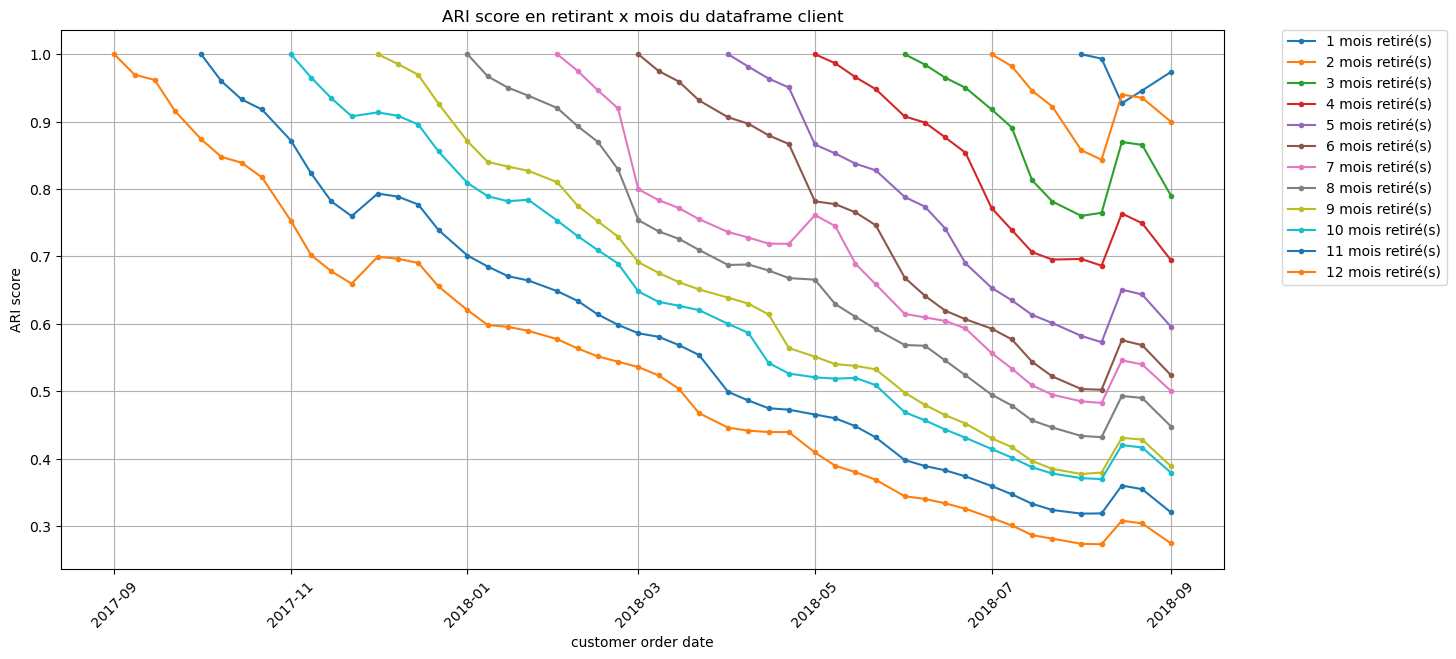

In [8]:
# Initialization of scaler and k-means for the beginning of the client dataframe
scaler_debut = StandardScaler()
kmeans_debut = KMeans(n_clusters=5, init='k-means++',
                      random_state=0, n_init=20)

# Initialization of the figure
plt.figure(figsize=(15, 7))
plt.xticks(rotation=45)
plt.grid(visible=True)

# First loop to successively subtract 1 to 12 months from the client dataframe
for i in range(1, 13):
    ari = pd.DataFrame(columns=['date', 'ARI_score'])
    ari['date'].astype('datetime64')
    mois = 9-i
    annee = 2018

    # Condition to switch from one year to the previous year (n-1)
    if mois < 1:
        mois = mois+12
        annee = annee-1

    # Construction of the features required for the model
    date_debut = date(annee, (mois), 1)
    df_full_debut = df_full_light.loc[:date_debut]
    df_debut = df_full_debut.reset_index().groupby(by=['customer_unique_id']).agg(
        last_order_purchase_timestamp=("order_purchase_timestamp", "max"),
        mean_order_price=('total_order_price', "mean"),
        mean_order_freight_value=('total_order_freight_value', "mean"),
        mean_review_score=('review_score', "mean"),
        frequence=("order_id", np.count_nonzero)
    ).reset_index()
    df_debut['mean_review_score'].fillna(
        df_debut['mean_review_score'].mean(), inplace=True)
    df_debut['recence'] = (df_debut['last_order_purchase_timestamp'].max(
    )-df_debut['last_order_purchase_timestamp']).dt.days
    df_debut['montant'] = df_debut['mean_order_price'] + \
        df_debut['mean_order_freight_value']
    df_debut = df_debut.drop({'customer_unique_id',
                              'last_order_purchase_timestamp',
                              'mean_order_price',
                              'mean_order_freight_value'}, axis=1).dropna()

    # Training of scaler M0 and transformation of the initial dataframe
    df_debut_scaled = scaler_debut.fit_transform(df_debut.values)

    # Training of the model M0 on the scaled dataframe
    kmeans_debut.fit(df_debut_scaled)

    # Second loop to add back the previously removed months
    for j in range(0, i):

        # Third loop to split each month into 4 weeks
        for k in [1, 8, 15, 22]:
            mois_intermediaire = mois+j
            annee_intermediaire = annee

            # CCondition to switch from one year to the next year (n+1)
            if mois_intermediaire > 12:
                mois_intermediaire = mois_intermediaire-12
                annee_intermediaire = annee_intermediaire+1

            # Construction of the features required for the model.
            date_intermediaire = date(
                annee_intermediaire, mois_intermediaire, (k))
            df_full_intermediaire = df_full_light.loc[:date_intermediaire]
            df_intermediaire = df_full_intermediaire.reset_index().groupby(by=['customer_unique_id']).agg(
                last_order_purchase_timestamp=(
                    "order_purchase_timestamp", "max"),
                mean_order_price=('total_order_price', "mean"),
                mean_order_freight_value=('total_order_freight_value', "mean"),
                mean_review_score=('review_score', "mean"),
                frequence=("order_id", np.count_nonzero)
            ).reset_index()
            df_intermediaire['mean_review_score'].fillna(
                df_intermediaire['mean_review_score'].mean(), inplace=True)
            df_intermediaire['recence'] = (df_intermediaire['last_order_purchase_timestamp'].max(
            )-df_intermediaire['last_order_purchase_timestamp']).dt.days
            df_intermediaire['montant'] = df_intermediaire['mean_order_price'] + \
                df_intermediaire['mean_order_freight_value']
            df_intermediaire = df_intermediaire.drop({'customer_unique_id',
                                                      'last_order_purchase_timestamp',
                                                      'mean_order_price',
                                                      'mean_order_freight_value'}, axis=1).dropna()

            # Scaling of the intermediate dataframe
            scaler_intermediaire = StandardScaler()
            df_intermediaire_scaled = scaler_intermediaire.fit_transform(
                df_intermediaire.values)
            kmeans_intermediaire = KMeans(
                n_clusters=5, init='k-means++', random_state=0, n_init=20)

            # Training of the intermediate model on the scaled dataframe
            kmeans_intermediaire.fit(df_intermediaire_scaled)

            # Scaling of the intermediate dataframe with the scaler M0
            df_intermediaire_scaled_M0 = scaler_debut.transform(
                df_intermediaire.values)

            # Recording of the date and ARI score between the intermediate model and the M0 model
            temp = pd.DataFrame([[date_intermediaire, adjusted_rand_score(kmeans_intermediaire.labels_,
                                                                          kmeans_debut.predict(df_intermediaire_scaled_M0))]], columns=['date', 'ARI_score'])
            ari = pd.concat([ari, temp])

    # Exit from weekly loops and usage of the final dataframe
    # Construction of the features required for the model
    df_final = df_full_light.reset_index().groupby(by=['customer_unique_id']).agg(
        last_order_purchase_timestamp=("order_purchase_timestamp", "max"),
        mean_order_price=('total_order_price', "mean"),
        mean_order_freight_value=('total_order_freight_value', "mean"),
        mean_review_score=('review_score', "mean"),
        frequence=("order_id", np.count_nonzero)
    ).reset_index()
    df_final['mean_review_score'].fillna(
        df_final['mean_review_score'].mean(), inplace=True)
    df_final['recence'] = (df_final['last_order_purchase_timestamp'].max(
    )-df_final['last_order_purchase_timestamp']).dt.days
    df_final['montant'] = df_final['mean_order_price'] + \
        df_final['mean_order_freight_value']
    df_final = df_final.drop({'customer_unique_id',
                              'last_order_purchase_timestamp',
                              'mean_order_price',
                              'mean_order_freight_value'}, axis=1).dropna()

    # Scaling of the final dataframe
    scaler_final = StandardScaler()
    df_final_scaled = scaler_final.fit_transform(df_final.values)

    # Training of the final model on the scaled dataframe
    kmeans_final = KMeans(
        n_clusters=5, init='k-means++', random_state=0, n_init=20)
    kmeans_final.fit(df_final_scaled)

    # Scaling of the final dataframe with the scaler M0
    df_final_scaled_M0 = scaler_debut.transform(df_final.values)

    # Recording of the date and ARI score between the final model and the M0 model
    date_finale = date(2018, 9, 1)
    temp = pd.DataFrame([[date_finale, adjusted_rand_score(kmeans_final.labels_,
                                                           kmeans_debut.predict(df_final_scaled_M0))]], columns=['date', 'ARI_score'])
    ari = pd.concat([ari, temp])

    # Plotting of the curve for each removed month
    plt.plot(ari['date'], ari['ARI_score'], '.-', label=f"{i} mois retiré(s)")

# End of the figure
plt.xlabel("customer order date")
plt.ylabel("ARI score")
plt.title("ARI score en retirant x mois du dataframe client")
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left', borderaxespad=0.)
plt.show()